### Setup

In [ ]:
install.packages('ggpubr')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘modelr’, ‘microbenchmark’, ‘Rdpack’, ‘doBy’, ‘boot’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘carData’, ‘Formula’, ‘nnet’, ‘pbkrtest’, ‘lme4’, ‘broom’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’




In [1]:
# load packages
library("dplyr")
#library("stringr")
library("data.table") 
library("ggplot2")
#library("tidyr")
library(scales)
#library(ggpubr)
library(grid)
#library('tidycmprsk')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [3]:
# load data
system("dx download vasilis/data/ukb_wb_del_cov_e4_dem_alz_phe.txt")
a <- fread("ukb_wb_del_cov_e4_dem_alz_phe.txt")
dim(a)
head(a)

[1] 407827     31

FID,IID,sex,age,batch,e4_status,dementia_status,dementia_incident,alz_status,alz_incident,⋯,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,delirium
<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1000015,1000015,1,82.0,50,1,0,NA,0,NA,⋯,1.574560,-2.916850,2.175070,1.907590,4.519030,-2.286550,3.96858,-0.788353,1.930670,0
1000053,1000053,0,54.7,19,2,0,NA,0,NA,⋯,0.694553,-0.654478,-0.361432,-1.871140,-6.937880,0.730852,7.18108,3.132090,-1.143680,0
1000132,1000132,0,71.6,44,0,0,NA,0,NA,⋯,-3.597410,0.352823,1.360030,1.547080,9.724700,-6.842110,4.99451,3.512240,-3.187870,0
1000148,1000148,0,54.3,38,0,0,NA,0,NA,⋯,0.918477,1.782720,6.454620,3.876280,16.265200,-0.318199,-2.53354,-2.746670,3.162380,0
1000163,1000163,1,54.1,94,0,0,NA,0,NA,⋯,-0.485291,-1.284440,-1.847220,0.604082,-1.672330,-0.158524,2.69347,0.116500,0.198556,0
1000419,1000419,0,54.6,58,1,0,NA,0,NA,⋯,-1.703480,-1.695770,-2.572730,1.905090,0.969051,-0.114667,-1.43691,-2.929790,-5.335960,0


### Stratify by dementia status

In [ ]:
## EUR
eur_dem   <- a %>% filter(dementia_status==1) # dementia cases
eur_nodem <- a %>% filter(dementia_status==0) # dementia controls

## AFR

## SAS

# summary
tt1 <- eur_dem %>% group_by(delirium) %>% summarise(n_dem=n())
tt2 <- eur_nodem %>% group_by(delirium) %>% summarise(n_nodem=n())
inner_join(tt1,tt2, by='delirium')

delirium,n_dem,n_nodem
<int>,<int>,<int>
0,5594,394711
1,2675,4847


### Stratify by Alzheimer status

In [5]:
## EUR
eur_alz   <- a %>% filter(alz_status==1) # alz cases
eur_noalz <- a %>% filter(alz_status==0) # alz controls

## AFR

## SAS

# summary
tt1 <- eur_alz %>% group_by(delirium) %>% summarise(n_alz=n())
tt2 <- eur_noalz %>% group_by(delirium) %>% summarise(n_noalz=n())
inner_join(tt1,tt2, by='delirium')

delirium,n_alz,n_noalz
<int>,<int>,<int>
0,2527,397778
1,1195,6327


In [9]:
## write tables
alz_dest     = 'vasilis/data/GWAS/sensitivity/alz_stratified/'

# EUR
eur_alz_file   = 'alzgroup_ukb_wb_del_cov_e4_dem_alz_phe.csv'
eur_noalz_file = 'noalzgroup_ukb_wb_del_cov_e4_dem_alz_phe.csv'

fwrite(eur_alz, eur_alz_file)
fwrite(eur_noalz, eur_noalz_file)

system(paste0('dx upload ', eur_alz_file, ' --dest ', alz_dest))
system(paste0('dx upload ', eur_noalz_file, ' --dest ', alz_dest))


### Startify by age

In [8]:
## EUR
eur_60plus  <- a %>% filter(age >= 60) 
eur_60minus <- a %>% filter(age < 60) 


In [16]:
tt1 <- eur_60plus %>% group_by(delirium) %>% summarise(n_60plus=n())
tt2 <- eur_60minus %>% group_by(delirium) %>% summarise(n_60minus=n())
inner_join(tt1,tt2, by='delirium')

delirium,n_60plus,n_60minus
<int>,<int>,<int>
0,348971,51334
1,7286,236


In [24]:
paste0('dx upload ', eur_60plus_file, ' --dest ', age_dest)

[1] "dx upload age60plus_ukb_wb_del_cov_e4_dem_phe.csv --dest vasilis/data/GWAS/sensitivity/age_stratified/"

In [25]:
## write tables
age_dest     = 'vasilis/data/GWAS/sensitivity/age_stratified/'

# EUR
eur_60plus_file  = 'age60plus_ukb_wb_del_cov_e4_dem_phe.csv'
eur_60minus_file = 'age60minus_ukb_wb_del_cov_e4_dem_phe.csv'

fwrite(eur_60plus, eur_60plus_file)
fwrite(eur_60minus, eur_60minus_file)

system(paste0('dx upload ', eur_60plus_file, ' --dest ', age_dest))
system(paste0('dx upload ', eur_60minus_file, ' --dest ', age_dest))


In [7]:
#install.packages("ggsurvfit")
#install.packages("survminer")
#library(ggsurvfit)
#library(survminer)

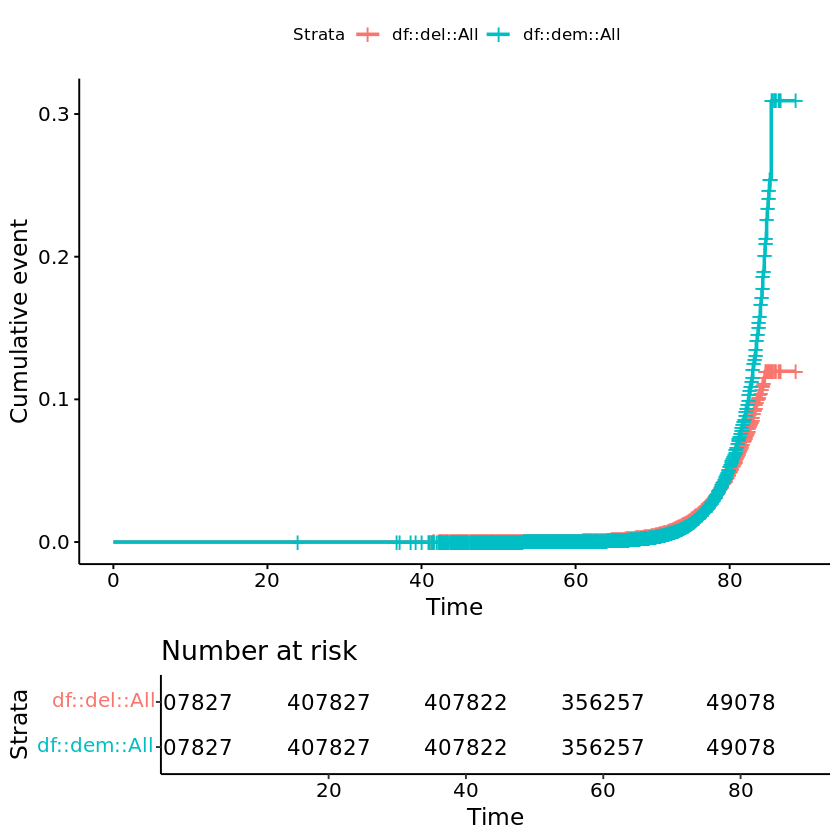

In [64]:
df <- a %>% select(age, delirium, dementia_status) #%>% mutate(age = round(age,0))
formulas <- list(
    del = Surv(age, delirium) ~ 1,
    dem = Surv(age, dementia_status) ~ 1)

fit <- surv_fit(formulas, data=df)
ggsurvplot_combine(fit, data=df, fun='event', risk.table = TRUE)

Plotting outcome "1".


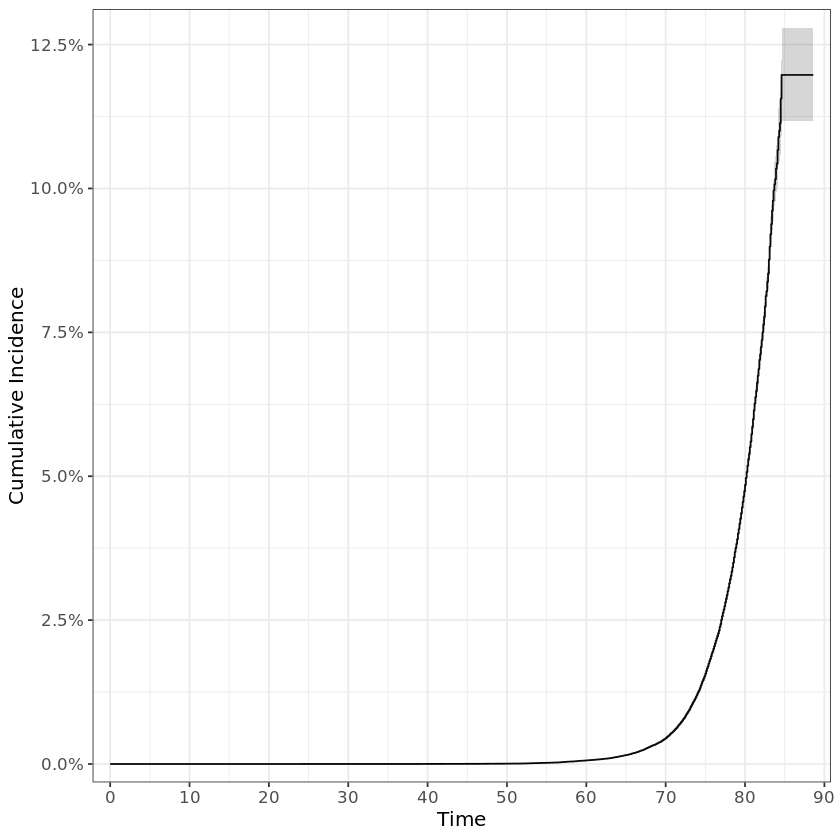

In [66]:
cuminc(Surv(age, as.factor(delirium)) ~ 1, a) %>%
  ggcuminc() +
  add_confidence_interval() +
  scale_ggsurvfit()

### Age distributions

#### UKB

#### a

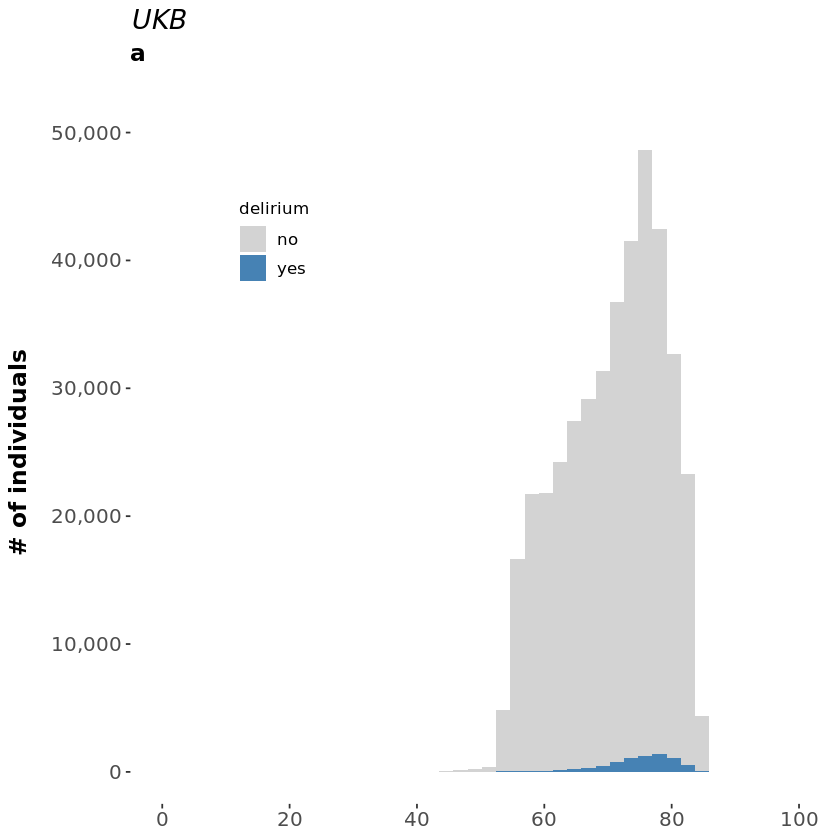

In [5]:
## age distribution (by delirium status)

a_hist <- a %>% select(age, delirium) %>% mutate(delirium = factor(delirium, levels = c('0','1')))
colors = c("lightgrey", "#4682B4")
xintercepts = seq(60,80,5)

agedist <- 
ggplot(data = a_hist, aes(x=age, fill=delirium)) +
    geom_histogram(aes(y=after_stat(count)), bins=30) +
    ## background, grids etc
    theme_bw() +
#    coord_cartesian(ylim = c(0,5)) +
    theme( 
        panel.grid.major = element_blank(),  
        panel.grid.minor = element_blank(), 
        panel.border = element_blank()
    ) +
    ## add title
    ggtitle(label = 'UKB', subtitle = 'a\n') +
    theme(plot.title = element_text(size=16, face = 'italic'),
          plot.subtitle = element_text(size=14, face = 'bold')) +
    ## change labels names, size & axis values
    labs(x = "\nAge (years)",
         y = "# of individuals\n",
         color = 'delirium') +
    theme(axis.text = element_text(size=12),
          axis.title = element_text(size=14, face="bold")) +
    scale_y_continuous(labels = comma, breaks = scales::pretty_breaks(n = 5)) +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
    ## change colors
    scale_fill_manual(labels = c('no', 'yes'), values = colors) + 
    ## change legend
    theme(
        legend.title = element_text(size=10),
        legend.text = element_text(size=10),
        legend.position = "inside",
        legend.position.inside = c(0.2,0.8)
    ) +
    ## coord. limits
    coord_cartesian(xlim =c(0,100), ylim = c(0,50000)) + 
    rremove("x.title") 

agedist
#ggsave(plot = agedist, filename = 'agedist.png', dpi=700)

#### extra

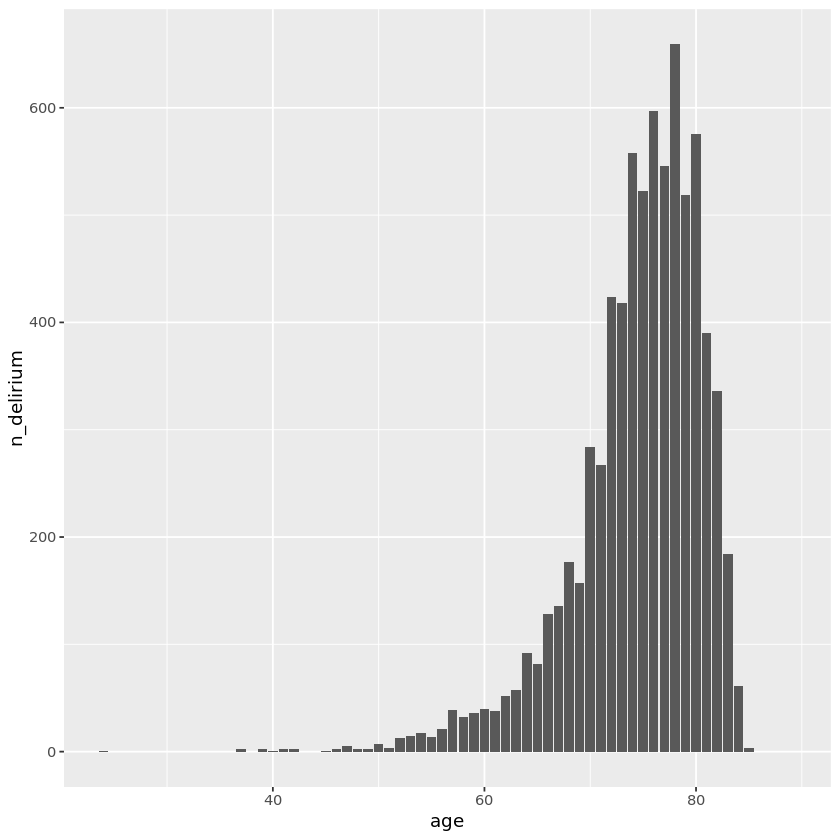

In [6]:
df <-
a %>% 
    select(age, delirium, dementia_status) %>%
    mutate(age = round(age,0)) %>% 
    arrange(age) %>% 
    group_by(age) %>% 
    summarise(n = n(),
              n_delirium = sum(delirium==1),
              n_dementia = sum(dementia_status==1)
             ) %>%
    #filter(age >=50) %>%
    mutate(pct_delirium = (n_delirium / n)*100,
           pct_dementia = (n_dementia / n)*100,
           pct_cs_delirium = cumsum(n_delirium))

ggplot(data = df, aes(x=age, y=n_delirium)) +
    geom_bar(stat='identity')

age_cat,n,n_delirium,n_dementia,pct_delirium,pct_dementia,pct_cs_delirium
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
60-,46561,219,89,0.4703507,0.1911471,219
60-64,55388,279,184,0.5037192,0.3322019,498
65-69,63655,680,506,1.0682586,0.7949101,1178
70-74,87025,1951,1625,2.2418845,1.8672795,3129
75-79,97703,2843,3265,2.9098390,3.3417602,5972
80+,57495,1550,2600,2.6958866,4.5221324,7522


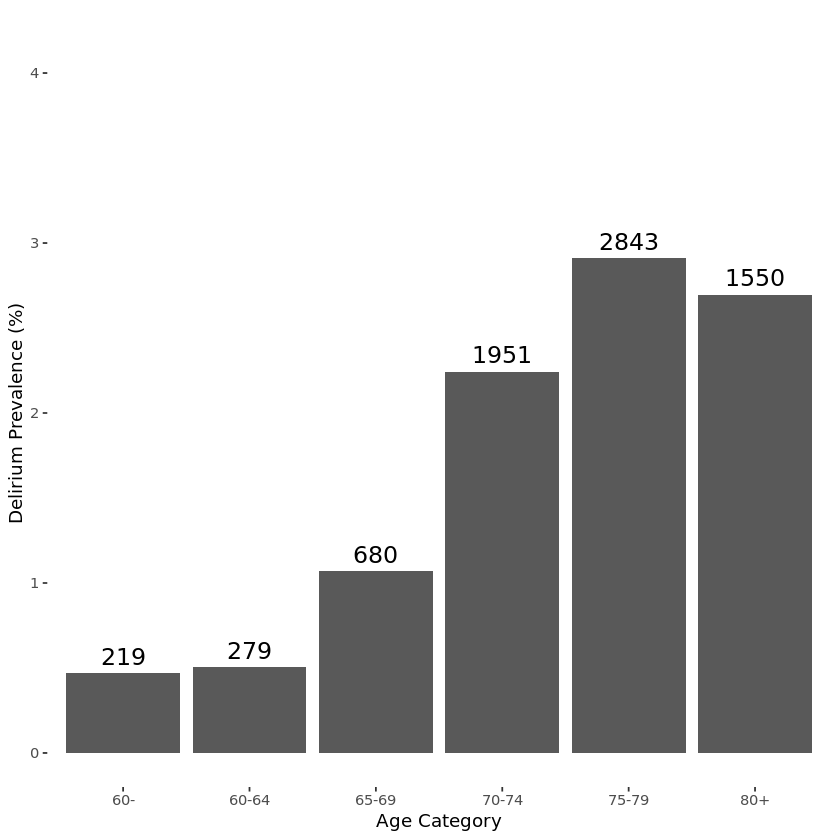

In [7]:
df_cat <-
a %>% 
    mutate(age = round(age,0)) %>% 
    arrange(age) %>% 
    mutate(age_cat = case_when( age < 60 ~ '60-',
                                #age < 50 ~ '-50',
                                #age >=50 & age < 55 ~ '50-54',
                                #age >=55 & age < 60 ~ '55-59',
                                age >=60 & age < 65 ~ '60-64',
                                age >=65 & age < 70 ~ '65-69',
                                age >=70 & age < 75 ~ '70-74',
                                age >=75 & age < 80 ~ '75-79',
                                #age >=80 & age < 85 ~ '80-84',
                                #age >=85 ~ '85+',
                                age >=80 ~ '80+',
                                TRUE ~ NA
                                ),
           age_cat = as.factor(age_cat)
          ) %>%
    group_by(age_cat) %>% 
    summarise(n = n(),
              n_delirium = sum(delirium==1),
              n_dementia = sum(dementia_status==1)
             ) %>%
    #filter(age >=50) %>%
    mutate(pct_delirium = (n_delirium / n)*100,
           pct_dementia = (n_dementia / n)*100,
           pct_cs_delirium = cumsum(n_delirium))
df_cat 
ggplot(df_cat, aes(x = age_cat, y = pct_delirium)) +
    
    geom_bar(stat = "identity") +
    geom_text(aes(label = n_delirium), vjust = -0.5, size = 5) +
    labs(title = "",
         x = "Age Category",
         y = "Delirium Prevalence (%)",) +
    theme_bw() +
    coord_cartesian(ylim = c(0,4)) +
    theme( 
        panel.grid.major = element_blank(),  
        panel.grid.minor = element_blank(), 
        panel.border = element_blank()
    )


#### b

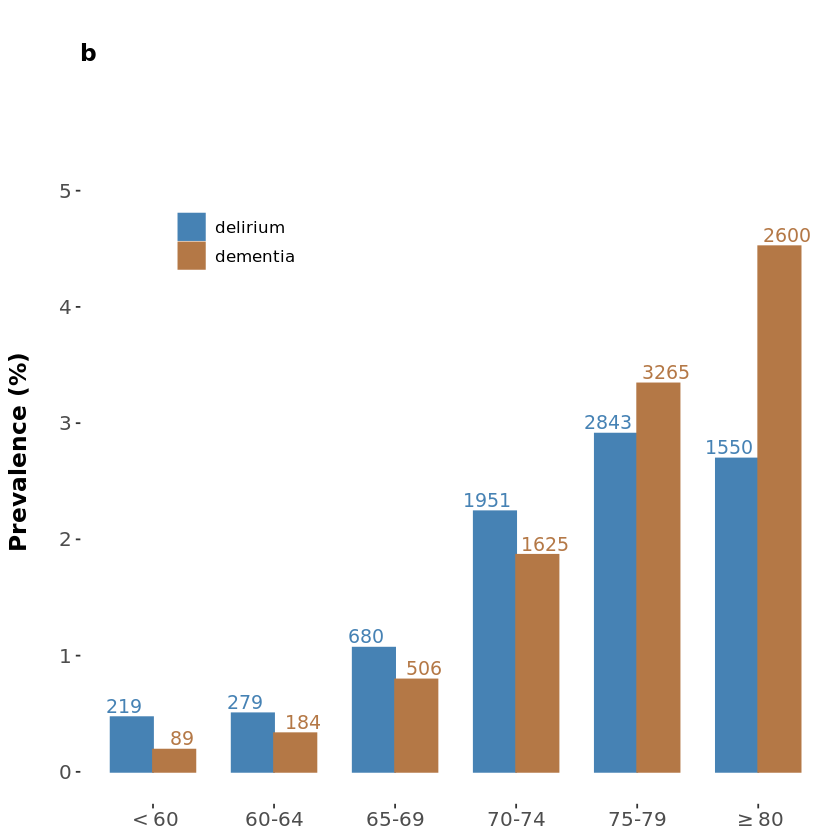

In [8]:
## prevelance of delirium and dementia by age group (UKB)
df_cat2a <-
    df_cat %>%
    select('age_cat', 'n_delirium', 'pct_delirium') %>%
    rename(n = n_delirium, pct=pct_delirium) %>%
    mutate(condition = 'delirium')

df_cat2b <- 
    df_cat %>%
    select('age_cat', 'n_dementia', 'pct_dementia') %>%
    rename(n = n_dementia, pct=pct_dementia) %>%
    mutate(condition = 'dementia')

df_cat2 <- bind_rows(df_cat2a,df_cat2b) %>% ungroup()

#colors = c("steelblue", complementary("steelblue"))
colors = c("#4682B4", "#B47846")
expr_labels = c(expression(""<60), levels(df_cat2$age_cat)[-c(1,length(levels(df_cat2$age_cat)))], expression("">=80))

deldem_prevdist <-
ggplot(df_cat2, aes(x = age_cat, y = pct, fill = condition, color = condition)) +
    ## histogram
    geom_col(position=position_dodge(0.7), width=0.7) +
    ## add text on top (n)
    geom_text(aes(label = n), vjust = -0.3, size = 4, position=position_dodge(0.95), show.legend  = FALSE) +
    ## background, grids etc
    theme_bw() +
    coord_cartesian(ylim = c(0,5.5)) +
    theme( 
        panel.grid.major = element_blank(),  
        panel.grid.minor = element_blank(), 
        panel.border = element_blank()
    ) +
   ## add title
    ggtitle(label = '', subtitle = 'b\n') +
    theme(plot.title = element_text(size=16, face = 'bold'),
          plot.subtitle = element_text(size=14, face = 'bold')) +
    ## change labels names, size & x-axis values
    labs(x = "\nAge Category (years)",
         y = "Prevalence (%)\n",) +
    theme(axis.text = element_text(size=12),
          axis.title = element_text(size=14, face="bold")) +
    scale_x_discrete(labels = expr_labels) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 5)) +
    ## change colors
    scale_fill_manual(values = colors) +
    scale_color_manual(values = colors) +
    ## change legend
    theme(
        legend.title = element_blank(),
        legend.text = element_text(size=10),
        legend.position = "inside",
        legend.position.inside = c(0.2,0.8)
    ) +
    rremove("x.title") 
deldem_prevdist
#ggsave(plot = deldem_prevdist, filename = 'deldem_previdist.png', dpi=700)

#### AoU

In [9]:
## load data
df_cat2_aou    <- readRDS('/mnt/project/vasilis/data/GWAS/from_AoU/df_cat2.rds')
pheno_hist_aou <- readRDS('/mnt/project/vasilis/data/GWAS/from_AoU/pheno_hist.rds')

#### c

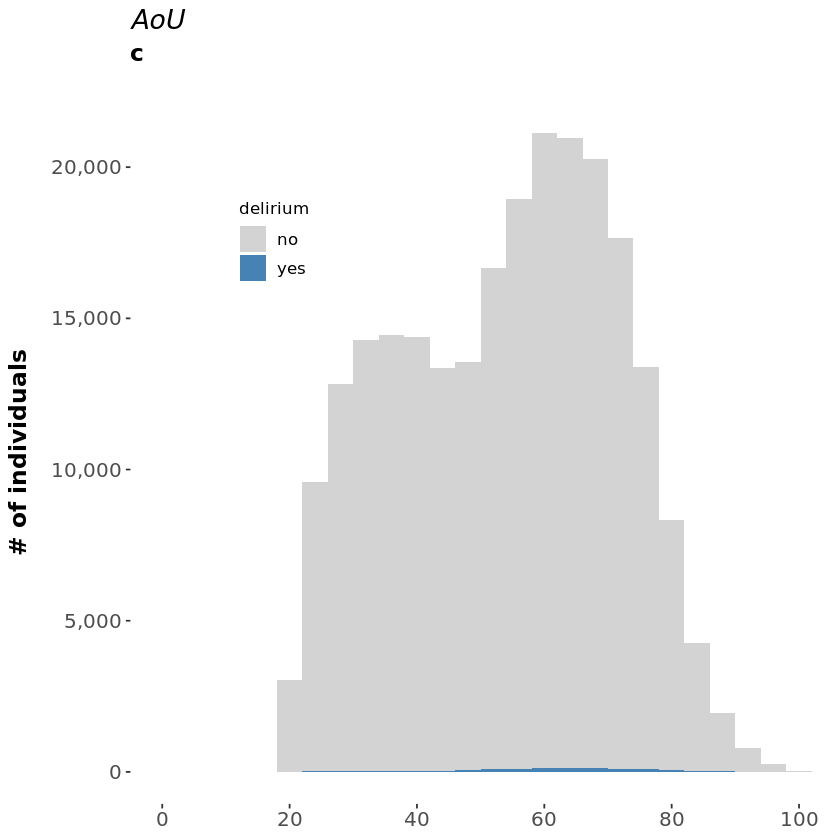

In [10]:
colors = c("lightgrey", "#4682B4")
xintercepts = seq(60,80,5)

agedist_aou <- 
ggplot(data = pheno_hist_aou, aes(x=age, fill=delirium)) +
    geom_histogram(aes(y=after_stat(count)), bins=30) +
    ## background, grids etc
    theme_bw() +
#    coord_cartesian(ylim = c(0,5)) +
    theme( 
        panel.grid.major = element_blank(),  
        panel.grid.minor = element_blank(), 
        panel.border = element_blank()
    ) +
    ## add title
    ggtitle(label = 'AoU', subtitle = 'c\n') +
    theme(plot.title = element_text(size=16, face = 'italic'),
          plot.subtitle = element_text(size=14, face = 'bold')) +
    ## change labels names, size & axis values
    labs(x = "\nAge (years)",
         y = "# of individuals\n",
         color = 'delirium') +
    theme(axis.text = element_text(size=12),
          axis.title = element_text(size=14, face="bold")) +
    scale_y_continuous(labels = comma, breaks = scales::pretty_breaks(n = 5)) +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 5)) +
    ## change colors
    scale_fill_manual(labels = c('no', 'yes'), values = colors) + 
    ## change legend
    theme(
        legend.title = element_text(size=10),
        legend.text = element_text(size=10),
        legend.position = "inside",
        legend.position.inside = c(0.2,0.8)
    ) +
    ## coord. limit
    coord_cartesian(xlim =c(0,100)) +
    rremove("x.title")    
agedist_aou
#ggsave(plot = agedist, filename = 'agedist.png', dpi=700)

#### d

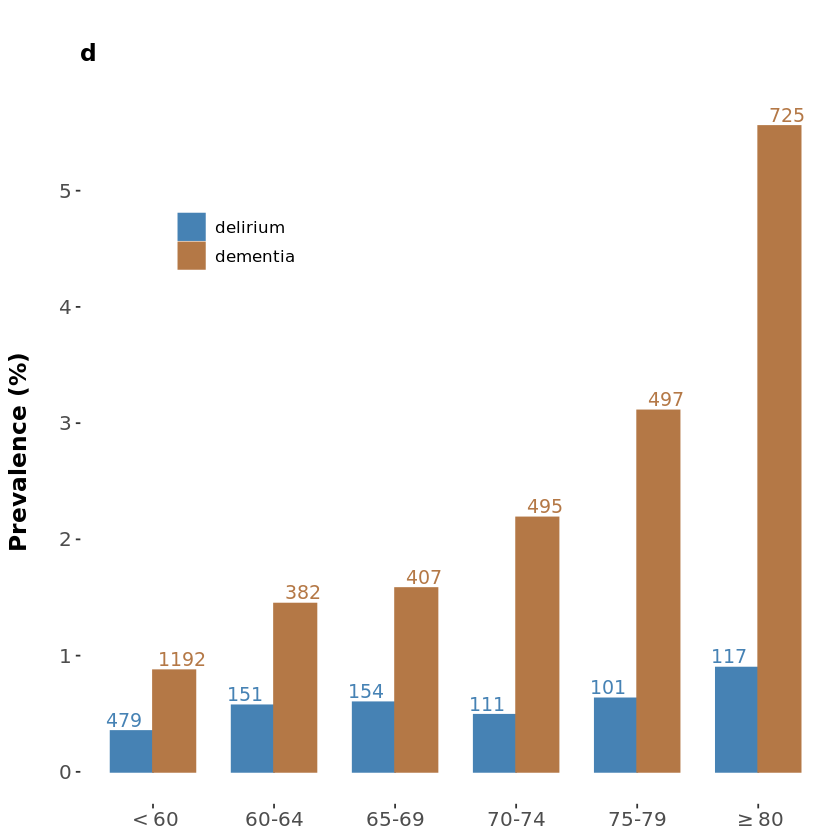

In [11]:
#colors = c("steelblue", complementary("steelblue"))
colors = c("#4682B4", "#B47846")
expr_labels = c(expression(""<60), levels(df_cat2_aou$age_cat)[-c(1,length(levels(df_cat2_aou$age_cat)))], expression("">=80))

deldem_prevdist_aou <-
ggplot(df_cat2_aou, aes(x = age_cat, y = pct, fill = condition, color = condition)) +
    ## histogram
    geom_col(position=position_dodge(0.7), width=0.7) +
    ## add text on top (n)
    geom_text(aes(label = n), vjust = -0.3, size = 4, position=position_dodge(0.95), show.legend  = FALSE) +
    ## background, grids etc
    theme_bw() +
    coord_cartesian(ylim = c(0,5.5)) +
    theme( 
        panel.grid.major = element_blank(),  
        panel.grid.minor = element_blank(), 
        panel.border = element_blank()
    ) +
    ## add title
    ggtitle(label = '', subtitle = 'd\n') +
    theme(plot.title = element_text(size=16, face = 'bold'),
          plot.subtitle = element_text(size=14, face = 'bold')) +
    ## change labels names, size & x-axis values
    labs(x = "\nAge Category (years)",
         y = "Prevalence (%)\n",) +
    theme(axis.text = element_text(size=12),
          axis.title = element_text(size=14, face="bold")) +
    scale_x_discrete(labels = expr_labels) +
    scale_y_continuous(labels = comma, breaks = scales::pretty_breaks(n = 5)) +
    ## change colors
    scale_fill_manual(values = colors) +
    scale_color_manual(values = colors) +
    ## change legend
    theme(
        legend.title = element_blank(),
        legend.text = element_text(size=10),
        legend.position = "inside",
        legend.position.inside = c(0.2,0.8)
    ) +
    rremove("x.title") 
deldem_prevdist_aou
#ggsave(plot = deldem_prevdist, filename = 'deldem_previdist.png', dpi=700)

Saving 14 x 14 in image


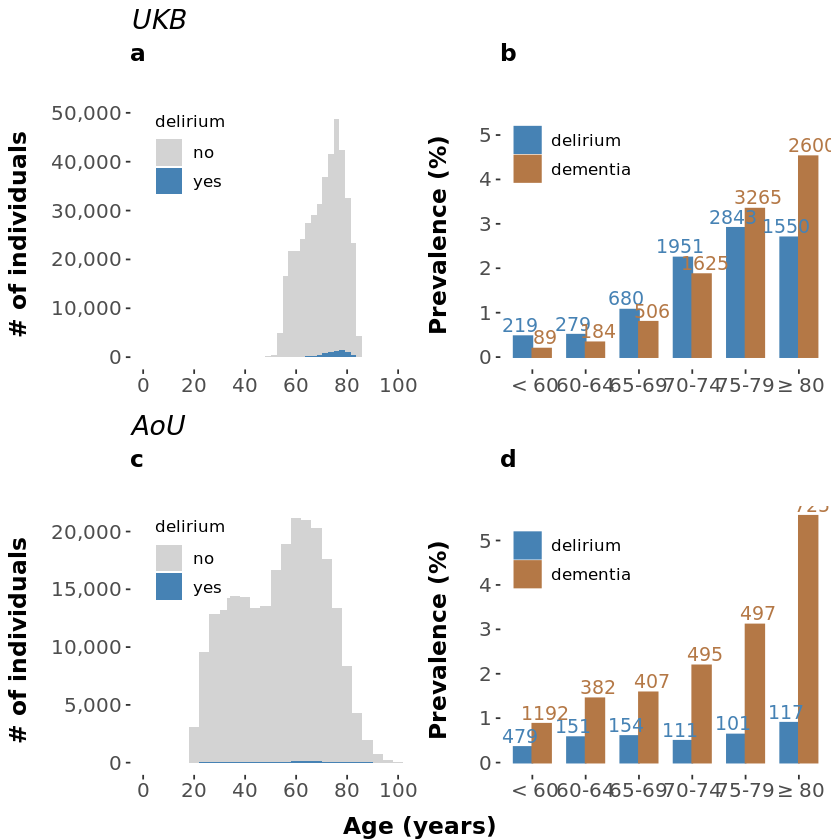

In [28]:
sf1 <- 
ggarrange(agedist, deldem_prevdist, agedist_aou, deldem_prevdist_aou,
          nrow = 2, ncol=2 
         )
library(grid)
sf1_annot <- annotate_figure(sf1, bottom = text_grob("Age (years)", color = "black", face = "bold", size = 14))
sf1_annot
ggsave(plot=sf1_annot, filename='sf1_ukb_aou.pdf', dpi=500, scale = 2)

In [29]:
## save
#system('dx upload deldem_previdist.png --dest vasilis/data/GWAS/plots/')
#system('dx upload agedist.png --dest vasilis/data/GWAS/plots/')
#system('dx upload st1.png --dest vasilis/data/GWAS/plots/')
system('dx upload sf1_ukb_aou.png --dest vasilis/data/GWAS/plots/')
system('dx upload sf1_ukb_aou.pdf --dest vasilis/data/GWAS/plots/')


In [ ]:
## rejects 
#df
# ggplot(data = df, aes(x=age, y=n_delirium)) +
#     geom_line() +
#     geom_point()

# df$pct5_delirium <- NA
# df$pct5_dementia <- NA

# for(x in seq(1,nrow(df))){
#     df[x,'pct5_delirium'] <- mean(df[seq(x,x+4),]$pct_delirium)
#     df[x,'pct5_dementia'] <- mean(df[seq(x,x+4),]$pct_dementia)
# }
